In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/background-burned-images/redcross_burned.jpg
/kaggle/input/background-burned-images/dumbbell_burned.jpg
/kaggle/input/background-burned-images/fashion2_burned.jpg
/kaggle/input/fitness-preprocessed/fitness_preprocessed.pkl


In [2]:
#General packages
import pandas as pd
import numpy as np
import pickle
import scipy.stats
from scipy.stats import norm
import scipy as sp

#Visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
# Build figures inline
%matplotlib inline

#NLP packages
from wordcloud import WordCloud

# Import scikit-learn tools, vectorizers, transformer, and classifiers
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score

# import CountVectorizer and TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

#Cross validation packages for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

In [3]:
fitness_df = pd.read_pickle('../input/fitness-preprocessed/fitness_preprocessed.pkl')
fitness_df.head()

,user_name,user_desc,location,following,followers,totaltweets,user_createdts,tweet_createdts,retweet_count,text,hashtags,num_hashtags,num_search_tags,label,tweet_length,% caps,manycaps,clean_tweet
0,anusualauthor,official tweet of Enigma Anu Aggarwal,"Mumbai, India",544,3743,2661,2010-04-30 12:38:54,2020-10-05 15:34:17,0,You get to know your #true #nature in that mom...,"{#bloom, #staysafe, #mentalhealth, #mindfulnes...",15,1,0,36,2.105263,False,get know #true #nature moment #bloom like flow...
7,IHealthtou,Welcome to I Health 2 U store!,United States,1,45,3205,2019-12-15 18:16:24,2020-10-05 15:33:33,0,13.58I Health 2 U#inspiration #wellness 310 ml...,{#wellness},1,1,0,15,11.111111,False,health u#inspiration #wellness ml large rectal...
9,KavitaRaoMD,Dr. Kavita Rao M.D. is a Gulf Coast internist ...,"St. Petersburg, FL",40,5,673,2014-12-19 18:06:56,2020-10-05 15:33:30,0,Love yourself enough to live a healthy lifesty...,"{#health, #wellness, #healthyliving}",3,2,0,13,4.629630,False,love enough live healthy lifestyle #health #we...
11,Crystal_Price13,Just me - all day - everyday,"Panama City, FL",60,445,12936,2013-05-21 23:46:02,2020-10-05 15:33:25,0,I thought you might enjoy a 5 minute break wit...,"{#healthylifestyle, #healthymind, #meditateany...",6,4,0,26,4.090909,False,thought might enjoy minute break brain smartph...
12,kelphr,"A dedicated HR Marketplace platform, perfectly...",India,415,314,1779,2013-09-12 14:26:26,2020-10-05 15:33:22,0,"With remote working becoming the norm, colleag...","{#remoteworking, #elearning, #sexualharassment...",10,1,0,30,4.729730,False,remote working becoming norm colleagues custom...


## Machine Learning on Fitness tweets

### Create X and y, split train and test data sets

In [4]:
# store the feature matrix (X) and response vector (y) of dataset
# uppercase X because it's an m x n matrix
# lowercase y because it's a m x 1 vector

X_fitness = fitness_df.clean_tweet
y_fitness = fitness_df.label

print(X_fitness.shape)
print(y_fitness.shape)

(41504,)
(41504,)


In [5]:
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fitness, y_fitness, random_state=42, test_size=0.3)

# Show the results of the split
print("X Training set sample size:", (X_train.shape[0]))
print("X Testing set sample size:", (X_test.shape[0]))
print("y Training set sample size:", (y_train.shape[0]))
print("y Testing set sample size:", (y_test.shape[0]))

X Training set sample size: 29052
X Testing set sample size: 12452
y Training set sample size: 29052
y Testing set sample size: 12452


### Vectorize, fit, create document-term matrix 

#### CountVectorizer

In [6]:
# Instantiate CountVectorizer
vect = CountVectorizer(min_df=1, ngram_range=(1, 2)) 

In [7]:
# Apply CountVectorizer to learn training data vocabulary, then use it to create a document-term matrix
X_train_dtm = vect.fit_transform(X_train)

# examine the document-term matrix
X_train_dtm

<29052x310806 sparse matrix of type '<class 'numpy.int64'>'
	with 888403 stored elements in Compressed Sparse Row format>

In [8]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<12452x310806 sparse matrix of type '<class 'numpy.int64'>'
	with 280694 stored elements in Compressed Sparse Row format>

#### TfidfVectorizer

In [9]:
# Instantiate TfidfVectorizer
tfidf = TfidfVectorizer(min_df=1, ngram_range=(1, 2))

In [10]:
# Apply TfidfVectorizer to learn training data vocabulary,then use it to create a document-term matrix
X_train_tfidf = tfidf.fit_transform(X_train)
X_train_tfidf

<29052x310806 sparse matrix of type '<class 'numpy.float64'>'
	with 888403 stored elements in Compressed Sparse Row format>

In [11]:
# transform testing data with tfidif vectorizer into document-term matrix
X_test_tfidf = tfidf.transform(X_test)
X_test_tfidf

<12452x310806 sparse matrix of type '<class 'numpy.float64'>'
	with 280694 stored elements in Compressed Sparse Row format>

### Build baseline model with Naive Bayes and compare vectorizers

In [12]:
# Instantiate MultinomialNB() classifier for CountVectorizer
nb = MultinomialNB(alpha=1, fit_prior=True)

# Train model
nb.fit(X_train_dtm, y_train)

# Make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

# Calculate F1 Score
f1 = metrics.f1_score(y_test, y_pred_class)

# Confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_class)

# Calculate predicted probabilities for X_test_dtm
y_pred_prob = nb.predict_proba(X_test_dtm)[:,1]

# Calculate AUC for Naive Bayes model with CountVec
auc = metrics.roc_auc_score(y_test, y_pred_class)

print(vect)
print('\nF1 Score: ', f1)
print('\nConfusion Matrix:\n', cm)
print('\nAUC: ', auc)

CountVectorizer(ngram_range=(1, 2))

F1 Score:  0.5794392523364486

Confusion Matrix:
 [[11996    15]
 [  255   186]]

AUC:  0.7102599261334706


In [13]:
# COMPARE TFIDF VECTORIZER

# instantiate MultinomialNB() classifier to use on tfidf vectors
nb_tfidf = MultinomialNB(alpha=1, fit_prior=True)

# train the model 
nb_tfidf.fit(X_train_tfidf, y_train)

# Make class predictions for X_test_tidf_baby
y_pred_tfidf = nb_tfidf.predict(X_test_tfidf)

# Calculate F1 Score
f1 = metrics.f1_score(y_test, y_pred_tfidf)

# Confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_tfidf)

# Calculate predicted probabilities for Xtest1
y_prob_tfidf = nb_tfidf.predict_proba(X_test_tfidf)[:,1]

# Calculate AUC for Naive Bayes model with Tfidf
auc = metrics.roc_auc_score(y_test, y_prob_tfidf)

print(tfidf)
print('\nF1 Score: ', f1)
print('\nConfusion Matrix:\n', cm)
print('\nAUC: ', auc)

TfidfVectorizer(ngram_range=(1, 2))

F1 Score:  0.13135593220338984

Confusion Matrix:
 [[12011     0]
 [  410    31]]

AUC:  0.8171778855021596


## Picking Hyperparameters

I want to look at the __alpha__ and __fit_prior__ to see if I can make the model better.

### GridSearchCV

__Run GridSearchCV on best parameters for CountVectorizer__

In [14]:
# run this to get a list of the all available pipe-items unique keys for the grid parameters
sorted(nb.get_params().keys())

['alpha', 'class_prior', 'fit_prior']

In [15]:
# Create a list of parameters for tuning
parameters = {'fit_prior': (True, False),
              'alpha': (0.001, 0.01, 0.1, 1, 5, 10),
             }

In [16]:
# Instantiate Vectorizer with new min_df 
vect = CountVectorizer(min_df=20, ngram_range=(1, 2)) 

# Apply CountVectorizer to learn training data vocabulary, then use it to create a document-term matrix
X_train_dtm = vect.fit_transform(X_train)

# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)

# Perform GridSearch on Naive Bayes using the given parameters and CountVectorizer
gs_count = GridSearchCV(MultinomialNB(), parameters, scoring='roc_auc', cv=5)
gs_count.fit(X_train_dtm, y_train)

# View the best score (set to roc_auc) for MultinomialNB with CountVect
print(gs_count)
print('\nBest Score: ', gs_count.best_score_)

# Get best parameters for MultinomialNB with CountVect
print('Best parameters:', gs_count.best_params_)
# Alpha = 1 is the default and picked as best alpha
# fit_prior: True (default)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': (0.001, 0.01, 0.1, 1, 5, 10),
                         'fit_prior': (True, False)},
             scoring='roc_auc')

Best Score:  0.8397706771263914
Best parameters: {'alpha': 0.01, 'fit_prior': True}


In [17]:
# Calculate predicted probabilities for X_test_dtm
y_prob_nb_count = gs_count.predict_proba(X_test_dtm)[:,1]

# Calculate AUC for Naive Bayes model with TfidfVectorizer
auc = metrics.roc_auc_score(y_test, y_prob_nb_count)

print('AUC: ', auc)

AUC:  0.8696471733866028


In [18]:
# Make class predictions for X_test_tidf
y_pred_dtm = gs_count.predict(X_test_dtm)

# Calculate F1 Score
f1 = metrics.f1_score(y_test, y_pred_dtm)

# Confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_dtm)
print('F1-score: {}'.format(f1))
print("Confusion Matrix: ")
print(cm)

F1-score: 0.5106382978723404
Confusion Matrix: 
[[11892   119]
 [  249   192]]


__Run GridSearchCV on best parameters for TfidfVectorizer__

In [19]:
# Instantiate Vectorizer with new min_df 
tfidf = TfidfVectorizer(min_df=20, ngram_range=(1, 2))

# Apply TfidfVectorizer to learn training data vocabulary,then use it to create a document-term matrix
X_train_tfidf = tfidf.fit_transform(X_train)

# transform testing data with tfidif vectorizer into document-term matrix
X_test_tfidf = tfidf.transform(X_test)


# Perform GridSearch on Naive Bayes using the given parameters and CountVectorizer
gs_tfidf = GridSearchCV(MultinomialNB(), parameters, scoring='roc_auc', cv=5)
gs_tfidf.fit(X_train_tfidf, y_train)

# View the best score (set to roc_auc) for MultinomialNB with TfidfVect
print(gs_tfidf)
print('\nBest Score: ', gs_tfidf.best_score_)

# Get best parameters for MultinomialNB with TfidfVect
print('Best parameters:', gs_tfidf.best_params_)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': (0.001, 0.01, 0.1, 1, 5, 10),
                         'fit_prior': (True, False)},
             scoring='roc_auc')

Best Score:  0.8476609233302849
Best parameters: {'alpha': 0.01, 'fit_prior': True}


In [20]:
# Calculate predicted probabilities for X_test_tfidf
y_prob_nb = gs_tfidf.predict_proba(X_test_tfidf)[:,1]

# Calculate AUC for Naive Bayes model with TfidfVectorizer
auc = metrics.roc_auc_score(y_test, y_prob_nb)

print('AUC: ', auc)

AUC:  0.8807406513794704


In [21]:
# Make class predictions for X_test_tidf
y_pred_tfidf = gs_tfidf.predict(X_test_tfidf)

# Calculate F1 Score
f1 = metrics.f1_score(y_test, y_pred_tfidf)

# Confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_tfidf)
print('F1-score: {}'.format(f1))
print("Confusion Matrix: ")
print(cm)

F1-score: 0.410958904109589
Confusion Matrix: 
[[11988    23]
 [  321   120]]


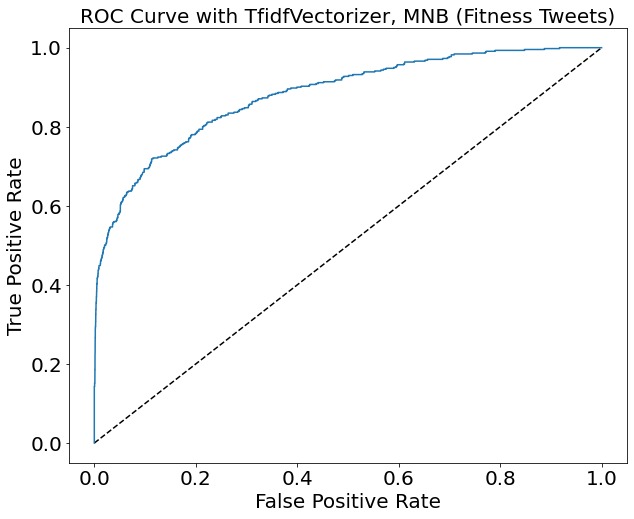

In [22]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob_nb)

# Plot ROC curve
plt.figure(figsize=(10,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('ROC Curve with TfidfVectorizer, MNB (Fitness Tweets)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

### Most Predictive Features

In [23]:
words = np.array(tfidf.get_feature_names())

# Create an identity matrix the length of the vocabulary
x = np.eye(X_test_tfidf.shape[1]) 

In [24]:
# Use the model to predict on the identity matrix, and get a list of probabilities for each word
probs = gs_tfidf.predict_log_proba(x)[:,0] 

In [25]:
# Sort for most/least probable words for any give class
ind = np.argsort(probs)

influencer_words = words[ind[:30]]
non_influencer_words = words[ind[-30:]]

influencer_prob = probs[ind[:30]]
non_influencer_prob = probs[ind[-30:]]

print("Influencer words\t     P(influencer | word)")
for w, p in zip(influencer_words, influencer_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Non Influencer words\t     P(Influencer | word)")
for w, p in zip(non_influencer_words, non_influencer_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Influencer words	     P(influencer | word)
             fanpage 1.00
       check fanpage 1.00
              gt abs 1.00
          fanpage gt 1.00
     healthy fashion 1.00
        healthissues 1.00
           find self 1.00
  luxuryhomemagazine 1.00
luxuryhomemagazine luxury 1.00
realestate luxurylife 1.00
     peace gedeprama 1.00
      gedeprama bali 1.00
        innerharmony 1.00
innerharmony joytrain 1.00
         bali beauty 1.00
  courtesy pinterest 1.00
           gedeprama 1.00
   holy innerharmony 1.00
      joytrain photo 1.00
 goodhealth research 1.00
healthcare goodhealth 1.00
research healthissues 1.00
healthissues wellness 1.00
   healthissues care 1.00
     care goodhealth 1.00
wellness healthissues 1.00
humanresources covid 1.00
    abs bodybuilding 0.97
  luxurylife realtor 0.97
         luxury home 0.97
Non Influencer words	     P(Influencer | word)
             writing 0.00
  fitness motivation 0.00
       quoteoftheday 0.00
       positivevibes 0.00
             bl

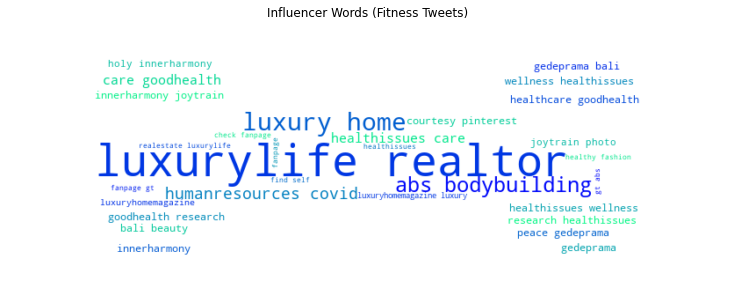

In [26]:
from PIL import Image

influencer_dict = {}
for w, p in zip(influencer_words, influencer_prob):
    influencer_dict[w] = p

# Read the mask image
fitness_mask = np.array(Image.open("../input/background-burned-images/dumbbell_burned.jpg"))
# Generate WordCloud images
wordcloud = WordCloud(max_font_size=50, max_words=50,mask=fitness_mask, background_color="white",colormap='winter').generate_from_frequencies(influencer_dict)

# Display the image
plt.figure(figsize = (10, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.title('Influencer Words (Fitness Tweets)')
plt.tight_layout(pad = 0) 

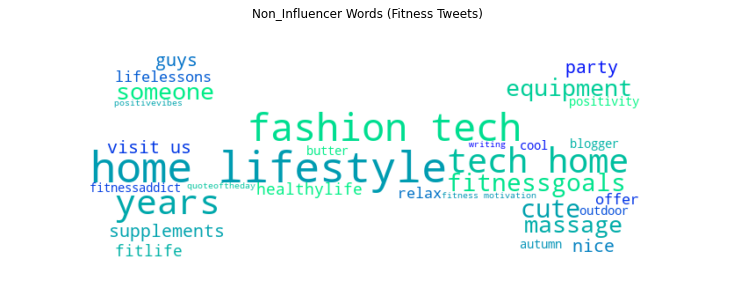

In [27]:
influencer_dict = {}
for w, p in zip(non_influencer_words, non_influencer_prob):
    influencer_dict[w] = p

# Generate WordCloud images
wordcloud = WordCloud(max_font_size=50, max_words=50,mask=fitness_mask, background_color="white",colormap='winter').generate_from_frequencies(influencer_dict)

# Display the image
plt.figure(figsize = (10, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.title('Non_Influencer Words (Fitness Tweets)')
plt.tight_layout(pad = 0) 

### Fit other Classifiers with TFIDF Vectorizer

#### 1. Logistic Regression

In [28]:
# Setup the hyperparameter grid
param_grid = {'C': np.arange(0.05, 4, 0.8),
              'l1_ratio': [0, 1]
              }
# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression(max_iter=1000)

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', n_jobs = -1)

# Fit it to the data
logreg_cv.fit(X_train_tfidf, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


Tuned Logistic Regression Parameters: {'C': 3.25, 'l1_ratio': 0}
Best score is 0.8479389243253642


In [29]:
pred_log_clf = logreg_cv.predict(X_test_tfidf)

# Calculate F1 Score
metrics.f1_score(y_test, pred_log_clf)

0.4828767123287672

In [30]:
# Calculate Predicted Probabilities,# keep probabilities for the positive outcome only
pred_prob_log_clf = logreg_cv.predict_proba(X_test_tfidf)[:,1]

# Determine ROC Score
metrics.roc_auc_score(y_test, pred_prob_log_clf)

0.8606118994096681

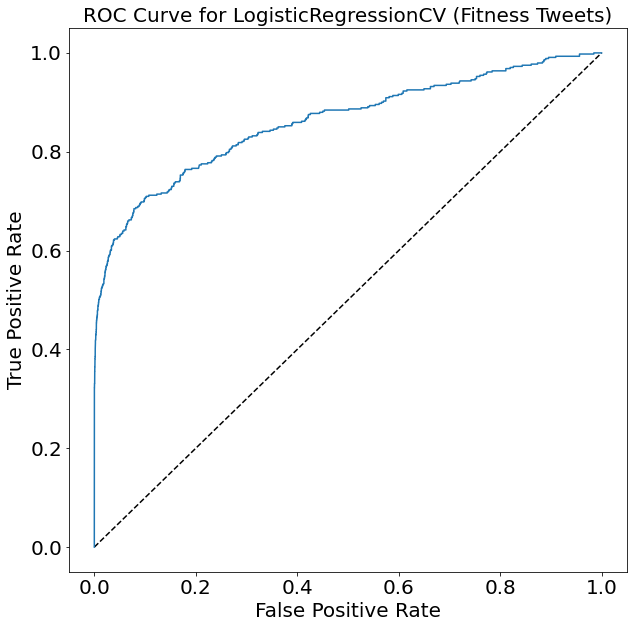

In [31]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, pred_prob_log_clf)

# Plot ROC curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('ROC Curve for LogisticRegressionCV (Fitness Tweets)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

#### 2. Random Forest

In [32]:
# Instantiate and fit Random Forests Model
rf_clf = RandomForestClassifier(class_weight='balanced',n_jobs = -1).fit(X_train_tfidf, y_train)


pred_rf_clf = rf_clf.predict(X_test_tfidf)

# Calculate F1 Score
metrics.f1_score(y_test, pred_rf_clf)

0.6839080459770114

In [33]:
# Create the parameter grid
parameters = {'max_features': ['sqrt', 'auto'],
              'max_depth': [10, 60, 100, None],
              'n_estimators': [50, 100, 300, 500]
              }

# Instantiate the grid search model
gs_rf = GridSearchCV(RandomForestClassifier(class_weight='balanced'), 
                     parameters, scoring='roc_auc', n_jobs=4, cv=3)

# Fit the grid search to the data
gs_rf.fit(X_train_tfidf, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=4,
             param_grid={'max_depth': [10, 60, 100, None],
                         'max_features': ['sqrt', 'auto'],
                         'n_estimators': [50, 100, 300, 500]},
             scoring='roc_auc')

In [34]:
# Get best parameters and best accuracy score
print('Best Score: ', gs_rf.best_score_)
print('Best Parameters: ', gs_rf.best_params_)

Best Score:  0.8805515135021437
Best Parameters:  {'max_depth': None, 'max_features': 'auto', 'n_estimators': 500}


In [35]:
# calculate predicted probabilities # keep probabilities for the positive outcome only
pred_prob_rf_clf = gs_rf.predict_proba(X_test_tfidf)[:, 1]

In [36]:
# Determine ROC score
metrics.roc_auc_score(y_test, pred_prob_rf_clf)

0.8947887150308741

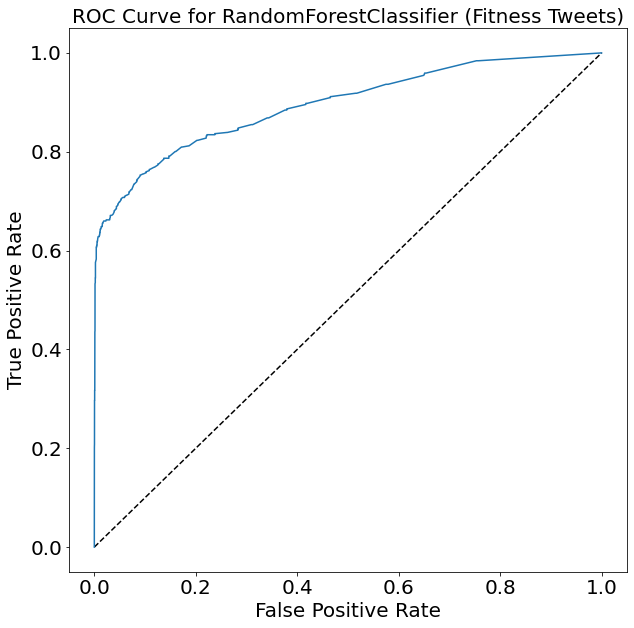

In [37]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, pred_prob_rf_clf)

# Plot ROC curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--',label='No Skill')
plt.plot(fpr, tpr, label='Logistic')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('ROC Curve for RandomForestClassifier (Fitness Tweets)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

## Thresholding for best model

#### Scoring metric: F1-Score

In [38]:
# Calculate Precision and Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, pred_prob_rf_clf)
thresholds = np.append(thresholds, 1)

In [39]:
# Define a function to apply threshold to positive probabilities to create labels
def to_labels(y_pred_prob, threshold):
    return (y_pred_prob >= threshold).astype('int')

In [40]:
# evaluate each threshold
scores = [metrics.f1_score(y_test, to_labels(pred_prob_rf_clf, t)) for t in thresholds]

# get best threshold
ix = np.argmax(scores)

print('Best Threshold=%.3f, F1-Score=%.5f' % (thresholds[ix], scores[ix]))
print()
print('Classification_Report:')
print(metrics.classification_report(y_test, to_labels(pred_prob_rf_clf, thresholds[ix])))

Best Threshold=0.272, F1-Score=0.70822

Classification_Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     12011
           1       0.85      0.61      0.71       441

    accuracy                           0.98     12452
   macro avg       0.92      0.80      0.85     12452
weighted avg       0.98      0.98      0.98     12452



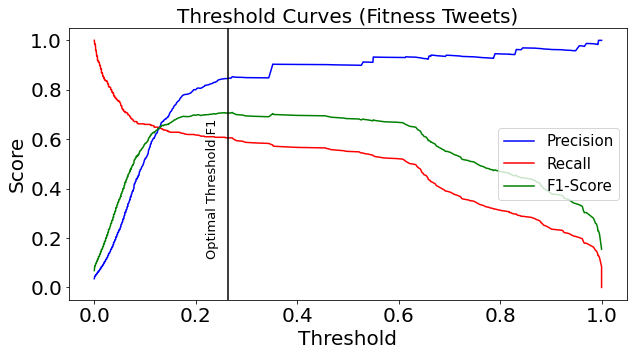

In [41]:
# Plot Precision, Recall and f1-Score on a graph together.

plt.figure(figsize=(10,5))
plt.plot(thresholds, precision, color='blue')
plt.plot(thresholds, recall, color='red')
plt.plot(thresholds, scores, color='green')
plt.title('Threshold Curves (Fitness Tweets)',fontsize=20)
plt.legend(('Precision', 'Recall', 'F1-Score'), loc='center right', fontsize=15)
plt.xlabel('Threshold', fontsize=20)
plt.ylabel('Score', fontsize=20)
plt.axvline(x=.264, color='black')
plt.text(.22,.13,'Optimal Threshold F1',rotation=90, fontsize=13)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()